In [134]:
import pandas as pd
import urllib.request, json
import pydotplus as pydotplus
from sklearn import preprocessing, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
import numpy as np

Funktsioon, millega saada andmed lehelt kätte. Tagastab andmed kujul [{}, {}, ... ,{}] ehk sõnastikke sisaldav massiiv, kus iga sõnastik hoiab infot ühe taotluse kohta


In [135]:
def getAndmed():
    with urllib.request.urlopen("https://toetused.kul.ee/public/applications/fetch?sort=submission_date%7Cdesc&page=1&per_page=20000000&applicant=&organization=&applicationround=&submissionDate=%7B%22start%22:null,%22end%22:null%7D") as f:
        data = json.load(f)
    andmed = data.get("data")
    return andmed

Tabeli tegemine

classes:  ['Arhitektuur ja disain' 'Audiovisuaal' 'Baasfinantseerimine'
 'Kultuur ja sport' 'Kultuur ja sport Ida-Virumaal' 'Kultuuripärand'
 'Mulgimaa pärimuskultuur' 'Muusika' 'Pereõpe' 'Raamatukogud'
 'Rahvakultuur' 'Rahvakultuuri keskseltsid' 'Rahvuskultuur' 'Regionaalia'
 'Regionaalne kultuuritegevus' 'Saarte pärimuskultuur' 'Sport' 'Teater'
 'Virumaa pärimuskultuur' 'Välissuhted']
Integer classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Accuracy: 1.0


C:\Users\enrih\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


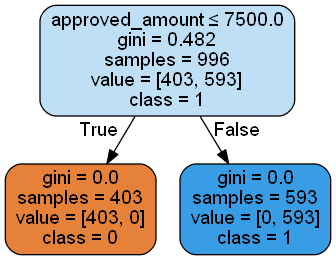

In [141]:
def tabel_andmetest():
    rawAndmed = getAndmed()
    
    id = []
    application_code = []
    applicationround_title = []
    approved_amount =[]
    cost_statement_submission_date = []
    cost_statement_submission_deadline = []
    managing_organization_name = []
    name = []
    project_name = []
    registration_date = []
    registry_code = []
    requested_amount = []
    status = []
    status_txt = []
    submission_date = []
    domain_code = []
    domain_name =[]
    
    for taotlus in rawAndmed:
        if taotlus.get("status") == "decision_ok":
            taotlus["status"] = 1
        elif taotlus.get("status") == "decision_not_ok":
            taotlus["status"] = 0
        else:
            taotlus["status"] = None
        
    
    for taotlus in rawAndmed:
        id.append(taotlus.get("id"))
        application_code.append(taotlus.get("application_code"))
        applicationround_title.append(taotlus.get("applicationround_title"))
        approved_amount.append(taotlus.get("approved_amount"))
        cost_statement_submission_date.append(taotlus.get("cost_statement_submission_date"))
        cost_statement_submission_deadline.append(taotlus.get("cost_statement_submission_deadline"))
        managing_organization_name.append(taotlus.get("managing_organization_name"))
        name.append(taotlus.get("name"))
        project_name.append(taotlus.get("project_name"))
        registration_date.append(taotlus.get("registration_date"))
        registry_code.append(taotlus.get("registry_code"))
        requested_amount.append(taotlus.get("requested_amount"))
        status.append(taotlus.get("status"))
        status_txt.append(taotlus.get("status_txt"))
        submission_date.append(taotlus.get("submission_date"))
        domain_code.append(taotlus.get("domain_code"))
        domain_name.append(taotlus.get("domain_name"))
    
    andmed = pd.DataFrame(
        {#"ID" : id,
        #"application_code" : application_code,
        #"applicationround_title" : applicationround_title,
        "approved_amount" : approved_amount,
        #"cost_statement_submission_date" : cost_statement_submission_date,
        #"cost_statement_submission_deadline" : cost_statement_submission_deadline,
        #"managing_organization_name" : managing_organization_name,
        #"name" : name,
        #"project_name" : project_name,
        #"registration_date" : registration_date,
        #"registry_code" : registry_code,
        "requested_amount" : requested_amount,
        "status" : status,
        #"status_txt" : status_txt,
        #"submission_date" : submission_date,
        #"domain_code" : domain_code,
        "domain_name" : domain_name
        }
    )
    return andmed

def decisionTree():
    tabel = tabel_andmetest()
    
    feature_cols = ["domain_name", "requested_amount", "approved_amount"]
    treenimiseks = tabel[(tabel.status.notnull())]
    
    X = treenimiseks[feature_cols]
    y = treenimiseks["status"]
    
    enc = preprocessing.LabelEncoder()
    label_encoder = enc.fit(tabel.domain_name.unique())
    print("classes: ", label_encoder.classes_)
    integer_classes = label_encoder.transform(label_encoder.classes_)
    print ("Integer classes:", integer_classes)
    t = label_encoder.transform(X.domain_name)
    X.domain_name = t
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
    dtc = DecisionTreeClassifier()
    
    dtc = dtc.fit(X_train, y_train)
    
    y_pred = dtc.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    import os
    
    os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
    dot_data = StringIO()
    export_graphviz(dtc, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_cols,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('diabetes.png')
    Image(graph.create_png())
    

In [ ]:
def biggestFounding():
    data = tabel_andmetest();
    most_expensive = data.loc[data['approved_amount'].idxmax()]
    applicationround_title = most_expensive["applicationround_title"]
    approved_amount = most_expensive["approved_amount"]
    managing_organization_name = most_expensive["managing_organization_name"]
    name = most_expensive["name"]
    project_name = most_expensive["project_name"]
    return applicationround_title, approved_amount, managing_organization_name, name, project_name
    


In [ ]:
def smallestFounding():
    data = tabel_andmetest();
    cheapest = data.loc[data['approved_amount'].idxmin()]
    applicationround_title = cheapest["applicationround_title"]
    approved_amount = cheapest["approved_amount"]
    managing_organization_name = cheapest["managing_organization_name"]
    name = cheapest["name"]
    project_name = cheapest["project_name"]
    return applicationround_title, approved_amount, managing_organization_name, name, project_name
print(smallestFounding())

In [ ]:
#Väike kasutajaliides 

